In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import corner_harris
from PIL import Image
import matplotlib.image as mpimg
sift = cv2.xfeatures2d.SIFT_create()
from skimage.feature import corner_harris
import matplotlib.image as mpimg
from scipy import spatial
from skimage.feature import peak_local_max
from matplotlib.patches import ConnectionPatch
# from corner_detector import corner_detector
# from anms import anms
from sklearn.neighbors import NearestNeighbors
# from feat_desc import feat_desc
# from feat_match import feat_match
from matplotlib.patches import ConnectionPatch
from ransac_est_homography import ransac_est_homography
from scipy import signal
from utils import GaussianPDF_2D
from utils import rgb2gray
from PIL import Image
from utils import visDerivatives
from utils import rgb2gray

In [2]:
def corner_detector(img):
  cimg = corner_harris(img, method='k', k=0.01, eps=1e-06, sigma=3)
  return cimg

In [3]:
# from queue import PriorityQueue
# '''
#   File clarification:
#     Implement Adaptive Non-Maximal Suppression. The goal is to create an uniformly distributed 
#     points given the number of feature desired:
#     - Input cimg: H × W matrix representing the corner metric matrix.
#     - Input max_pts: the number of corners desired.
#     - Outpuy x: N × 1 vector representing the column coordinates of corners.
#     - Output y: N × 1 vector representing the row coordinates of corners.
#     - Output rmax: suppression radius used to get max pts corners.
# '''

# # def anms(cimg, max_pts):
# #   # Your Code Here
# #   result = peak_local_max(cimg, num_peaks = max_pts)
# #   x = result[:,1]
# #   y = result[:,0]
# #   rmax = 1
# #   return x, y, rmax

# def anms(cimg, max_pts):
#   # Your Code Here
#   H = cimg.shape[0]
#   W = cimg.shape[1]
#   ###########################################################
#   ## comment this section out after first run to save time ##
#   ###########################################################
#   q = PriorityQueue()
#   print(H,W)
#   for i in range(H):
#     for j in range(W):
#       q.put((-cimg[i,j],[i,j]))
#   points = []
#   for i in range(2000):
#     points+=[q.get()[1]]
#   np.save('out', points)
#   ###########################################################
#   points=np.load('out.npy')
#   print(points.shape, len(points))

#   q = PriorityQueue()
#   i=0
#   for p1 in points:
#     d=100000
#     value = cimg[p1[0],p1[1]]
#     for p2 in points:
#       v = cimg[p2[0],p2[1]]
#       if v>value and v<=value*1.2:
#         d=min(d,((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**(1/2))
#     q.put((-d,i,p1))
#     i+=1
#   x=[]
#   y=[]
#   rmax=0
#   for i in range(max_pts):
#     result = q.get()
#     x+=[result[2][1]]
#     y+=[result[2][0]]
#     rmax=-result[0]
#   return x, y, rmax

In [7]:
LOW_THRESH = 1
HIGH_THRESH = 0

def anms(corner_matrix, max_pts):
  h, w = corner_matrix.shape[0:2]
  inf = float("inf")

  ''' Preparing corner map '''

  # Low thresholding based on mean value of the corner matrix
  mean_value = np.mean(corner_matrix)
  threshold = LOW_THRESH * mean_value
  corner_matrix[np.where(corner_matrix < threshold)] = 0.0

  # From thresholded corner map, find the local maxima
  corner_coords = peak_local_max(corner_matrix, min_distance=1, exclude_border=True)
  num_corners = corner_coords.shape[0]


  ''' Prepare the M*M distance matrix '''

  # a[i,j] == distance between ith and jth corners
  distances = np.zeros((num_corners, num_corners)).astype(float)
  idx = np.arange(0, num_corners)

  # Iterative version
  for i in idx:
    this_coords = corner_coords[i]

    for j in idx:
      other_coords = corner_coords[j]

      # Compute distance
      distances[i,j] = np.sqrt((this_coords[0] - other_coords[0])**2 + (this_coords[1] - other_coords[1])**2)

  # Set self distances to infinity
  distances[idx, idx] = inf

  # For each corner...
  for i in idx:
    this_coords = corner_coords[i]
    this_corner = corner_matrix[this_coords[0], this_coords[1]]

    # Check against every other corner...
    other_corners = corner_matrix[corner_coords[:,0], corner_coords[:,1]]
    j = np.where(other_corners < HIGH_THRESH * this_corner)
    distances[i, j] = inf


  ''' Find the optimal points from the distance matrix '''

  # Get the argmin from each row
  closest_maxima = np.argmin(distances, axis=1)
  rmax = np.max(np.min(distances, axis=1))

  # Best corners are the minima of each each row
  best_corners = np.unique(corner_coords[closest_maxima], axis=0)


  ''' If we get more than max_pts, just keep the best of those '''
  if (best_corners.shape[0] > max_pts):
    corner_values = corner_matrix[best_corners[:,0], best_corners[:,1]]

    # Get the smallest possible point we're going to keep
    all_chosen = np.flipud(np.sort(corner_values))
    top_threshold = all_chosen[max_pts]

    # Get rid of indices corresponding to smaller points
    best_corners = best_corners[np.where(corner_values > top_threshold)]


  ''' Return '''
  x = best_corners[:,1]
  y = best_corners[:,0]
  return x, y, rmax

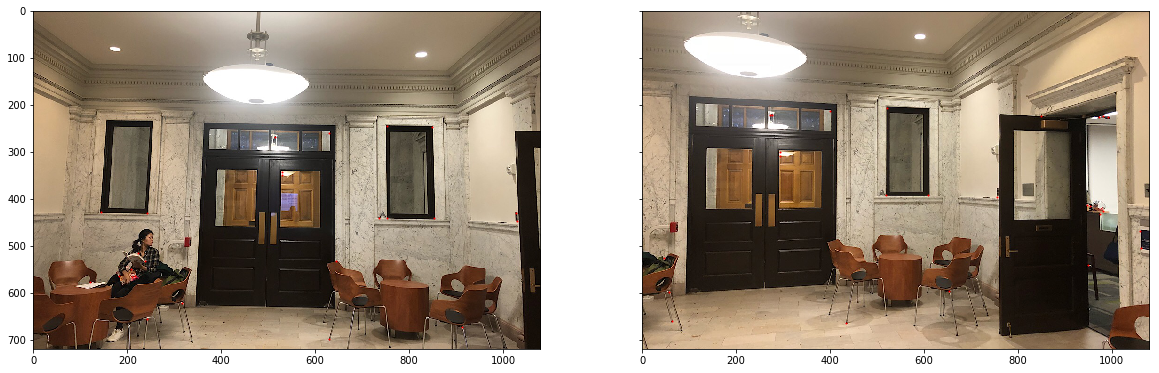

In [62]:
# Step 1 && Step 2
img_1 = mpimg.imread("our_middle.jpg")
gray_1 = rgb2gray(img_1)
img_2 = mpimg.imread("our_right.jpg")
gray_2 = rgb2gray(img_2)
# img_1 = cv2.imread('left.jpg')
# img_2 = cv2.imread('middle.jpg')
# gray_1=cv2.imread("left.jpg",0)
# gray_2=cv2.imread("middle.jpg",0)
cimg_1 = corner_detector(gray_1)
cimg_2 = corner_detector(gray_2)
x_1,y_1,r_max_1 = anms(cimg_1,25)
x_2,y_2,r_max_2 = anms(cimg_2,25)
x_1 = np.asarray(x_1)
y_1 = np.asarray(y_1)
x_2 = np.asarray(x_2)
y_2 = np.asarray(y_2)
fig, (ax,ay) = plt.subplots(1, 2, sharey=True)
ax.imshow(img_1)
ay.imshow(img_2)
ax.plot(x_1, y_1, color='r', marker='o',
        linestyle='None', markersize=1)
ay.plot(x_2, y_2, color='r', marker='o',
        linestyle='None', markersize=1)
plt.show()

In [63]:
print(x_1.shape)

(25,)


In [64]:
DESC_SIZE = 64

def feat_desc(image, x, y):
  h, w = image.shape[0:2]
  num_corners = x.shape[0]
  corners = np.array((y, x))

  # Offsets
  offsets_row = np.tile(np.arange(-17.5, 20, 5), (8,1)).transpose()
  offsets_col = np.tile(np.arange(-17.5, 20, 5), (8,1))
  offsets = np.array((np.ravel(offsets_row), np.ravel(offsets_col)))

  ''' Loop: for each corner, generate descriptor '''
  descriptors = np.zeros( (DESC_SIZE, num_corners) )
  for n in np.arange(0, num_corners):

    # Get the current y,x pair
    corner = corners[:,n]

    # Generate indices of the pixels we will sample from
    sample_idx = offsets + corner.reshape((2,1))
    ## todo: deal with out of bounds (negative pixels and >h,w pixels)
    ## just replace with zeros in the sample???
    sample_idx = np.round(sample_idx).astype(int)
    sample_idx[0, sample_idx[0] < 0] = 0
    sample_idx[1, sample_idx[1] < 0] = 0
    sample_idx[0, sample_idx[0] >= h] = h-1
    sample_idx[1, sample_idx[1] >= w] = w-1
    # Sample the pixels from the image, and reshape + standardize to form the descriptor
    samples = image[sample_idx[0], sample_idx[1]]
    descriptors[:,n] = (samples - np.mean(samples)) / np.std(samples)

  return descriptors

In [65]:
descs1 = feat_desc(gray_1,x_1,y_1)
descs2 = feat_desc(gray_2,x_2,y_2)

In [60]:
print(descs1.shape)

(64, 50)


In [10]:
def findDerivatives(I_gray): 
    G = GaussianPDF_2D(0, 1, 5, 5)
    dx, dy = np.gradient(G, axis = (1,0))
    Magx = signal.convolve2d(I_gray,dx,'same')
    Magy = signal.convolve2d(I_gray,dy,'same')
    Mag = np.sqrt(Magx*Magx+Magy*Magy)
    Ori = np.arctan2(Magy, Magx)
    return Mag, Ori

In [11]:
def feat_desc_2(img, x, y):
    Mag, Ori = findDerivatives(img)
    des_size = 64
    des = np.zeros([des_size,x.shape[0]])
    dummy_patch = np.arange(-20,20,5)
    dummy_space = np.arange(0,5)
    space_x,space_y = np.meshgrid(dummy_space,dummy_space)
    patch_x, patch_y = np.meshgrid(dummy_patch,dummy_patch)
    patch_x, patch_y = patch_x.flatten(), patch_y.flatten()

    for j in range(x.shape[0]):
        for i in range(patch_x.shape[0]):
            patch_top_x = x[j]+patch_x[i]
            patch_top_y = y[j]+patch_y[i]

            patch_space_x = np.full((5, 5), patch_top_x)
            patch_space_x = patch_space_x + space_x

            patch_space_y = np.full((5, 5), patch_top_y)
            patch_space_y = patch_space_y + space_y

            patch_space_y = np.clip(patch_space_y, 0, img_1.shape[0] - 1).astype(np.int32)
            patch_space_x = np.clip(patch_space_x, 0, img_1.shape[1] - 1).astype(np.int32)

    #         print(patch_space_x)
    #         print(patch_space_y)
        #     mag_matrix = Mag_1[patch_space_y,patch_space_x]
        #     mag_max = np.amax(mag_matrix)
            mag_max = np.amax(Mag[patch_space_y,patch_space_x])
            des[i,j] = mag_max

    for i in range(0, des.shape[1]):
        des[:,i] = des[:,i] - np.mean(des[:,i])
        des[:,i] = des[:,i] / np.std(des[:,i])
    return des

In [219]:
# # Hand Write feature desciptor
def feat_desc(img, x, y):
    
    patch_size = 8
    space = 5
    vx = np.arange(-space * patch_size/2, space * patch_size/2, space)
    vy = vx
    patch_x, patch_y = np.meshgrid(vx,vy)
    patch_x[:,int(patch_size/2):] += space
    patch_y[int(patch_size/2):,:] += space
    patch_x, patch_y = patch_x.flatten(), patch_y.flatten()
    
    offset_x = np.tile(patch_x,(x.shape[0],1)) + np.tile(np.array([x]).T, (1, patch_x.shape[0]))
    offset_y = np.tile(patch_y,(y.shape[0],1)) + np.tile(np.array([y]).T, (1, patch_y.shape[0]))
    offset_x = np.clip(offset_x, 0, img.shape[1] - 1).astype(np.int32)
    offset_y = np.clip(offset_y, 0, img.shape[0] - 1).astype(np.int32)
    
    des = np.zeros((x.shape[0], patch_size*patch_size)) 
    des = img[offset_y, offset_x].astype(np.float64)

    for i in range(0, des.shape[0]):
        des[i] = des[i] - np.mean(des[i])
        norm = np.linalg.norm(des[i])
        des[i] = des[i] / norm

    return des


In [31]:
# initialize parameter
def feat_match(descs1,descs2):
    descs1 = descs1.T
    descs2 = descs2.T
    N = descs1.shape[0]
    descriptor_size = 64
    match = np.zeros(N).astype(int)
    match.fill(-1)
    threshold = 0.7

    nbrs_farward = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(descs2)
    distances_farward, indices_farward = nbrs_farward.kneighbors(descs1)

    # bi-directional check
#     nbrs_backward = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(descs1)
#     distances_backward, indices_backward = nbrs_backward.kneighbors(descs2)

    for i in range(N):
        ratio_farward = distances_farward[i,0] / distances_farward[i,1]
#         ratio_backward = distances_backward[i,0] / distances_backward[i,1]
        if ratio_farward < threshold:
#         if ratio_farward < threshold and ratio_backward < threshold:
            match[i] = indices_farward[i,0]
        
    return match

[ 0  2  3  4  5  6 11]
[ 0  1  2  8  9 10 11]


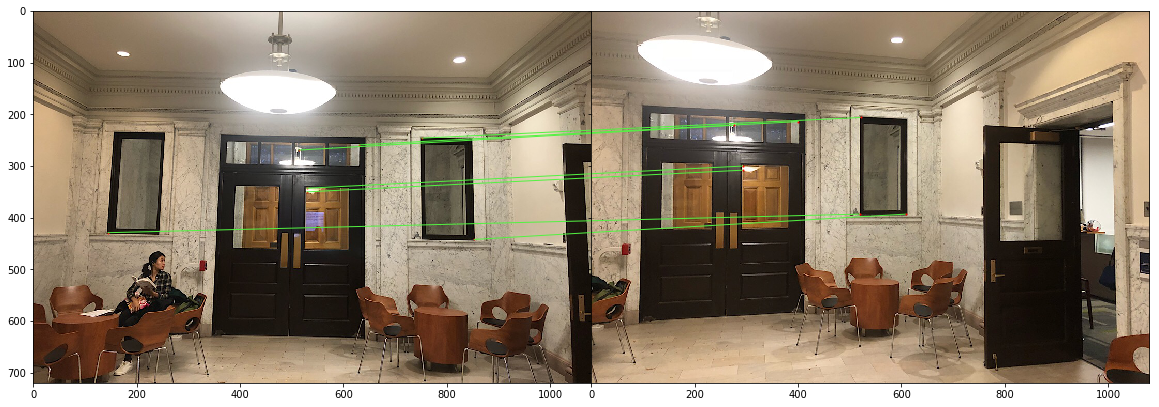

In [66]:
# Step 3 & 4
# descs1 = feat_desc(gray_1,x_1,y_1)
# descs2 = feat_desc(gray_2,x_2,y_2)
match = feat_match(descs1, descs2)
idx_1 = np.argwhere(match > -1)
idx_1 = idx_1.flatten()
print(idx_1)
idx_2 = np.take(match,idx_1)
idx_2 = idx_2.astype(int)
print(idx_2)
draw_x1 = x_1[idx_1]
draw_y1 = y_1[idx_1]
draw_x2 = x_2[idx_2]
draw_y2 = y_2[idx_2]

# Display Result
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plt.rcParams['figure.figsize'] = [20, 20]
ax1.imshow(img_1)
ax1.plot(draw_x1, draw_y1, color='r', marker='o',
        linestyle='None', markersize=1)

ax2.imshow(img_2)
ax2.plot(draw_x2, draw_y2, color='r', marker='o',
        linestyle='None', markersize=1)


for i in range(draw_x1.size):
    xy1 = (draw_x1[i],draw_y1[i])
    xy2 = (draw_x2[i],draw_y2[i])
    con = ConnectionPatch(xyA=xy2, xyB=xy1, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color='#53F242')
    ax2.add_artist(con)

plt.subplots_adjust(wspace=0, hspace=0)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [399]:
print(draw_x1)

[3322 3674 2727  774 1231]


In [427]:
ransac_H, inline_idx = ransac_est_homography(draw_x1, draw_y1, draw_x2, draw_y2, 0.5)

----------- ransac_est_homography -----------
[ransac_est_homography] total number of points:  18
update!
num_inline: 3
ssd:
 [2.63587264e+06 1.99484126e+04 2.74505746e+05 4.41540998e-19
 5.82129416e+05 7.84763606e+05 5.96330491e+04 1.48715059e+05
 6.13707563e+06 6.67573636e+06 6.62814386e+05 2.65063912e+05
 1.50034379e+06 2.89853640e+05 1.59003846e+06 1.94028551e-19
 2.53470001e+03 8.48346564e-17]
update!
num_inline: 4
ssd:
 [3.67768203e-16 3.75460988e+05 2.52963649e+05 7.35752599e+04
 1.64440345e+06 6.47566380e+05 2.99609901e+05 1.97905673e+05
 2.64090705e+05 2.58435774e+05 1.64814454e-16 2.24160271e-16
 6.12902002e+07 1.19007302e+05 1.18303160e+09 1.70157021e+09
 2.27460496e+01 2.74846736e-17]
update!
num_inline: 5
ssd:
 [4.73208276e+08 2.53020147e+06 8.86247451e+06 6.63010179e+05
 5.91609530e+06 3.84297393e+05 4.69037027e+06 1.38551096e+05
 5.22362732e+01 1.20699408e-16 1.96576244e+05 5.13832694e-17
 1.31579477e-16 5.77528303e+03 1.90670978e+04 1.38214901e+06
 5.05227132e-18 4.1165

In [428]:
print(inline_idx)

[0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1]


[[ 9]
 [11]
 [12]
 [16]
 [17]]


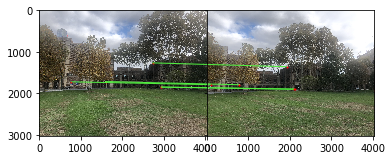

In [429]:
dummy = np.argwhere(inline_idx == 1)
print(dummy)
ran_idx_x1 = draw_x1[dummy]
ran_idx_y1 = draw_y1[dummy]
ran_idx_x2 = draw_x2[dummy]
ran_idx_y2 = draw_y2[dummy]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

ax1.imshow(img_1)
ax1.plot(ran_idx_x1, ran_idx_y1, color='r', marker='o',
        linestyle='None', markersize=1)

ax2.imshow(img_2)
ax2.plot(ran_idx_x2, ran_idx_y2, color='r', marker='o',
        linestyle='None', markersize=1)


for i in range(ran_idx_x1.size):
    xy1 = (ran_idx_x1[i],ran_idx_y1[i])
    xy2 = (ran_idx_x2[i],ran_idx_y2[i])
    con = ConnectionPatch(xyA=xy2, xyB=xy1, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color='#53F242')
    ax2.add_artist(con)

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

In [432]:
thresh = 0.5

img_m = mpimg.imread('right.jpg')
img_l = mpimg.imread('middle.jpg')
NUM_channels = 3

def show_ransac(x1,x2,y1,y2):
    big_im = np.concatenate((img_l, img_m), axis=1)

    plt.imshow(big_im)

    x2_shift = x2 + img_m.shape[1]
    for i in range(x1.shape[0]):
        if inline_idx[i] == 1:
            plt.plot([x1[i], x2_shift[i]], [y1[i], y2[i]], marker="o")
    plt.show()

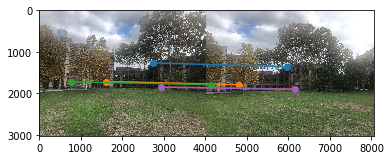

In [433]:
show_ransac(draw_x1,draw_x2,draw_y1,draw_y2)